In [2]:
#Image classification assignment using vggnet, resnet models
# STEP 1: Unzip the dataset 5

import zipfile
import os

# Path to the ZIP file
zip_path = "/content/dataset5.zip"

# Directory where you want to extract
exdataset_path = "/content/dataset5ex"

# Create the directory if it doesn't exist
os.makedirs(exdataset_path, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(exdataset_path)

print(f"Dataset extracted to: {exdataset_path}")


Dataset extracted to: /content/dataset5ex


In [3]:
# Image classification assignment using vggnet, resnet models
# STEP 2: Process the training, test and validation dataset and create loaders

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Constants for preprocessing
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 224
BATCH_SIZE = 32  # Example batch size, can be adjusted

# Define transforms for training with augmentation
# Resize 224x224 and Normalize, Add random cropping and flipping
# Imported transform from torchvision
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize a bit larger for random crop
    transforms.RandomResizedCrop(IMAGE_SIZE),  # Random crop to 224x224
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# Define transforms for validation and test (no augmentation)
# Resize 224x224 and Normalize, Add random cropping and flipping
# Imported transform from torchvision
val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

def valid_file(dataset_path):
    return dataset_path.endswith(('.jpg', '.jpeg', '.png', '.ppm','.bmp',
                                  '.pgm', '.tif', '.tiff', '.webp', '.JPEG'))

# Get dataloader for Train dataset and Validation Dataset
def get_dataloaders(dataset_path, batch_size=BATCH_SIZE):
    train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train",
                                         transform=train_transforms,
                                         is_valid_file=valid_file)
    val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val",
                                       transform=val_test_transforms,
                                       is_valid_file=valid_file)

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader


#train_loader, val_loader = get_dataloaders('/content/drive/MyDrive/dataset5')
train_loader, val_loader = get_dataloaders('/content/dataset5ex/dataset5')

# Quick sanity check
for images, labels in train_loader:
    print(f"Train batch: {images.shape}, Labels: {labels.shape}")
    break

for images, labels in val_loader:
    print(f"Validation batch: {images.shape}, Labels: {labels.shape}")
    break



Train batch: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])
Validation batch: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])


In [4]:
# STEP 3: Create selection function for different model
# Input parameters: model name - resnet18/resnet34/vgg19
#                   feature extract : True/False
#                   num of classes
# Output parameters: model

import torch
import torch.nn as nn
from torchvision import models

def select_model(model_name, num_classes=10, feature_extract=True):
    if model_name == 'resnet18':
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'resnet34':
        model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'vgg19':
        model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)

    # Freeze feature extractor if desired
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze only classifier layers
        for param in model.parameters():
            if param.requires_grad:
                break
    print(f"Selected Pre-Trained Model Name: {model_name}")
    return model

In [5]:
# STEP 4: Create selection function for optimizer and scheduler
# Input parameters: model, Optimizer: SGD/Adam, learning rate, momentum,
#                   weight decay, Scheduler: StepLR/CosineAnnealingLR,
#                   step_size, gamma
# Output parameters: optimizer, scheduler

import torch.optim as optim

def select_optimizer_scheduler(model, optimizer_name='SGD',
                               lr=0.01,momentum=0.9, weight_decay=1e-4,
                               scheduler_name='StepLR',
                               step_size=7, gamma=0.1):
# Optimizer
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum,
                              weight_decay=weight_decay)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr,
                               weight_decay=weight_decay)
    else:
        raise ValueError('Unsupported optimizer')
# Scheduler
    if scheduler_name == 'StepLR':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                              gamma=gamma)
    elif scheduler_name == 'CosineAnnealingLR':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    else:
        scheduler = None
    print(f"Selected Optimizer:{optimizer_name}, Scheduler:{scheduler_name}")
    print(f"StepSize:{step_size}, LR:{lr}, Gamma:{gamma}")
    print(f"WgtDecay:{weight_decay}, Momentum:{momentum}")

    return optimizer, scheduler


In [12]:
# STEP 5: Create Utility function for Training and Validaiton
# STEP 5.1: Create Training Epoch Loop
# Input parameters: model, train_loader, val_loader, criterion,scheduler,
#                   optimizer, num_epochs
# Output parameters: train_acc_list, test_acc_list

import matplotlib.pyplot as plt
# Create a training loop
def training_loop(model, train_loader, val_loader, criterion,scheduler, optimizer, num_epochs):
    model = model.to(device)
    train_acc_list = []
    val_acc_list = []
    for epoch in range(num_epochs):
      # Training loop
        correct, total = 0, 0
        running_loss = 0.0
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item() * labels.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        train_acc_list.append(train_acc)
        if scheduler:
            scheduler.step()

        # Validation loop
        model.eval()
        correct, total = 0, 0
        val_loss = 0.0
        with torch.no_grad():
            for images_val, labels_val in val_loader:
                images_val, labels_val = images_val.to(device), labels_val.to(device)
                outputs_val = model(images_val)
                loss_val = criterion(outputs_val, labels_val)
                _, predicted = torch.max(outputs_val.data, 1)
                total += labels_val.size(0)
                correct += (predicted == labels_val).sum().item()
                val_loss += loss_val.item() * images_val.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = correct / total
        val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}, TrainAccuracy:{100 * train_acc:.2f}%,TrainLoss:{100 * train_loss:.2f}%")
    print(f"Epoch {epoch+1}, ValAccuracy:{100 * val_acc:.2f}%,ValLoss:{100 * val_loss:.2f}%")

    return train_acc_list, val_acc_list

# STEP 5.2: Create Test Epoch Loop
# Input parameters: model, test_loader, num_epochs
# Output parameters: test_acc_list

def test_loop(model, test_loader, num_epochs):
    model = model.to(device)
    test_acc_list = []
    correct, total = 0, 0
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.0
    for epoch in range(num_epochs):
        # Validation loop
        model.eval()

        with torch.no_grad():
            for images_test, labels_test in test_loader:
                images_test, labels_test = images_test.to(device), labels_test.to(device)
                outputs_test = model(images_test)
                loss_test = criterion(outputs_test, labels_test)
                _, predicted = torch.max(outputs_test.data, 1)
                total += labels_test.size(0)
                correct += (predicted == labels_test).sum().item()
                test_loss += loss_test.item() * images_test.size(0)

        test_loss /= len(test_loader.dataset)
        test_acc = correct / total
        test_acc_list.append(test_acc)
    print(f"Epoch {epoch+1}, TestAccuracy:{100 * test_acc:.2f}%,TestLoss:{100 * test_loss:.2f}%")
    return test_acc_list

# STEP 5.3: Create a function for plotting accuracy
# Input parameters: train_acc, test_acc
# Output parameters: None

def plotAccuracy(train_acc, test_acc):
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Train Acc', linestyle='--')
    plt.plot(test_acc, label='Test Acc', linestyle='-')
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy")
    plt.title("BatchNorm Impact on CNN Performance")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Aug 29 12:28:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P0             53W /  400W |     423MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [7]:
# STEP 6: Create a function based on different pre-trained model and parameters
# Input parameters: model_name='resnet18/resnet34/vgg19',
#                   train_loader, val_loader, optimizer_name='Adam/SGD',
#                   learning rate, momentum, weight_decay,
#                   scheduler_name='StepLR/CosineAnnealingLR',
#                   step_size,gamma
# Output parameters: model

import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

def training_diff_model(model_name='resnet18',
                        train_loader=train_loader, val_loader=val_loader,
                        optimizer_name='Adam', lr=0.0001, momentum=0.9,
                        weight_decay=0.0001, scheduler_name='StepLR',
                        step_size=7,gamma=0.1):
    print(f"-----------------Experiment Start-------------------------------")

    criterion = nn.CrossEntropyLoss()


    # Select Model
    model = select_model(model_name, num_classes = 10, feature_extract=True)

    # Unfreeze parameters before creating optimizer
    for param in model.parameters():
        param.requires_grad = True

    # Select optimizer and scheduler
    optimizer, scheduler = select_optimizer_scheduler(
        model=model, optimizer_name=optimizer_name, lr=lr, momentum=momentum,
        weight_decay=weight_decay, scheduler_name=scheduler_name,
        step_size=step_size, gamma=gamma)

    # Training Epoch loop
    train_acc, test_acc = training_loop(
        model, train_loader, val_loader, criterion, scheduler, optimizer, num_epochs=30)

    # Plot accuracy
    plotAccuracy(train_acc, test_acc)
    print(f"-----------------Experiment over-------------------------------")
    return model


-----------------Experiment Start-------------------------------
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


Selected Pre-Trained Model Name: resnet18
Selected Optimizer:Adam, Scheduler:StepLR
StepSize:7, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9
Epoch 30, TrainAccuracy:89.94%,TrainLoss:30.77%
Epoch 30, ValAccuracy:78.80%,ValLoss:76.40%


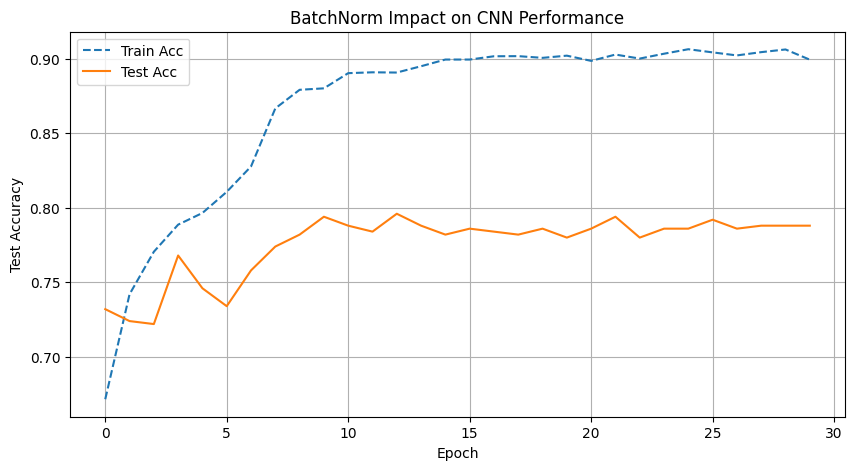

-----------------Experiment over-------------------------------
-----------------Experiment Start-------------------------------
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 200MB/s]


Selected Pre-Trained Model Name: resnet34
Selected Optimizer:Adam, Scheduler:StepLR
StepSize:7, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9
Epoch 30, TrainAccuracy:91.83%,TrainLoss:24.43%
Epoch 30, ValAccuracy:79.60%,ValLoss:82.45%


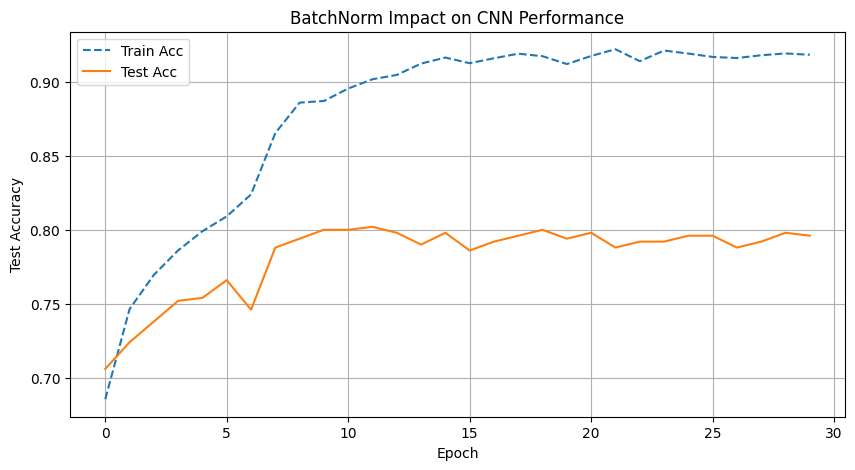

-----------------Experiment over-------------------------------
-----------------Experiment Start-------------------------------
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 223MB/s]


Selected Pre-Trained Model Name: vgg19
Selected Optimizer:Adam, Scheduler:StepLR
StepSize:7, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9
Epoch 30, TrainAccuracy:87.66%,TrainLoss:38.01%
Epoch 30, ValAccuracy:79.60%,ValLoss:71.75%


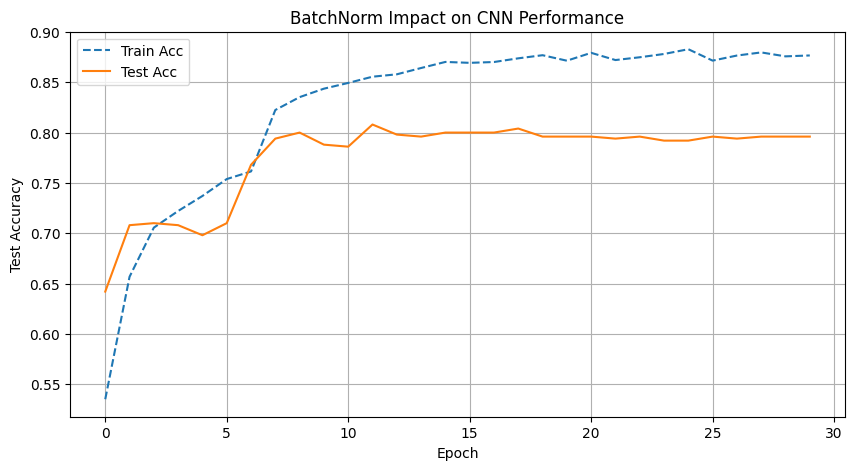

-----------------Experiment over-------------------------------


In [8]:
# STEP 7: Experiment with different pre-trained model and parameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_RESNET18_Adam_SLR_lr0001_mom09_decay0001_step7
model = training_diff_model(model_name='resnet18',
                        train_loader=train_loader, val_loader=val_loader,
                        optimizer_name='Adam', lr=0.0001, momentum=0.9,
                        weight_decay=0.0001, scheduler_name='StepLR',
                        step_size=7,gamma=0.1)
#save the model
torch.save(model, 'model_RESNET18_Adam_SLR_lr0001_mom09_decay0001_step7.pth')

# model_RESNET34_Adam_SLR_lr0001_mom09_decay0001_step7
model = training_diff_model(model_name='resnet34',
                        train_loader=train_loader, val_loader=val_loader,
                        optimizer_name='Adam', lr=0.0001, momentum=0.9,
                        weight_decay=0.0001, scheduler_name='StepLR',
                        step_size=7,gamma=0.1)
#save the model
torch.save(model, 'model_RESNET34_Adam_SLR_lr0001_mom09_decay0001_step7.pth')

# model_VGG19_Adam_SLR_lr0001_mom09_decay0001_step7
model = training_diff_model(model_name='vgg19',
                        train_loader=train_loader, val_loader=val_loader,
                        optimizer_name='Adam', lr=0.0001, momentum=0.9,
                        weight_decay=0.0001, scheduler_name='StepLR',
                        step_size=7,gamma=0.1)
#save the model
torch.save(model, 'model_VGG19_Adam_SLR_lr0001_mom09_decay0001_step7.pth')



-----------------Experiment Start-------------------------------
Selected Pre-Trained Model Name: resnet18
Selected Optimizer:Adam, Scheduler:StepLR
StepSize:10, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9
Epoch 30, TrainAccuracy:92.69%,TestAccuracy:77.80%


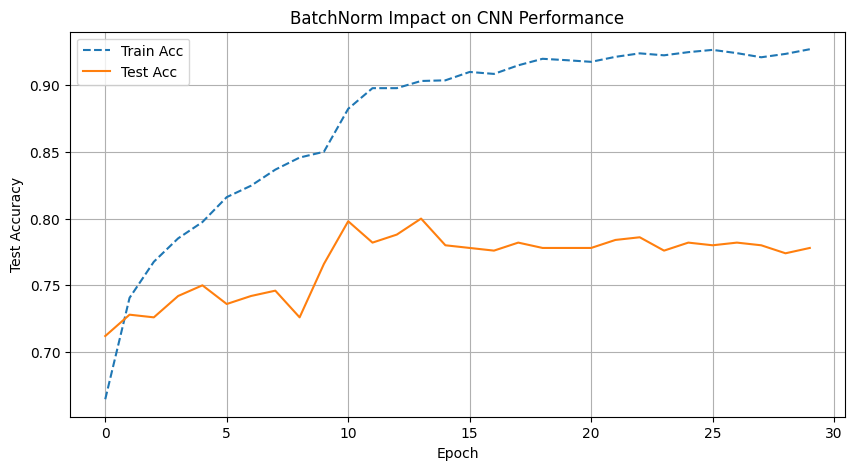

-----------------Experiment over-------------------------------
-----------------Experiment Start-------------------------------
Selected Pre-Trained Model Name: resnet18
Selected Optimizer:Adam, Scheduler:CosineAnnealingLR
StepSize:7, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9
Epoch 30, TrainAccuracy:93.72%,TestAccuracy:79.00%


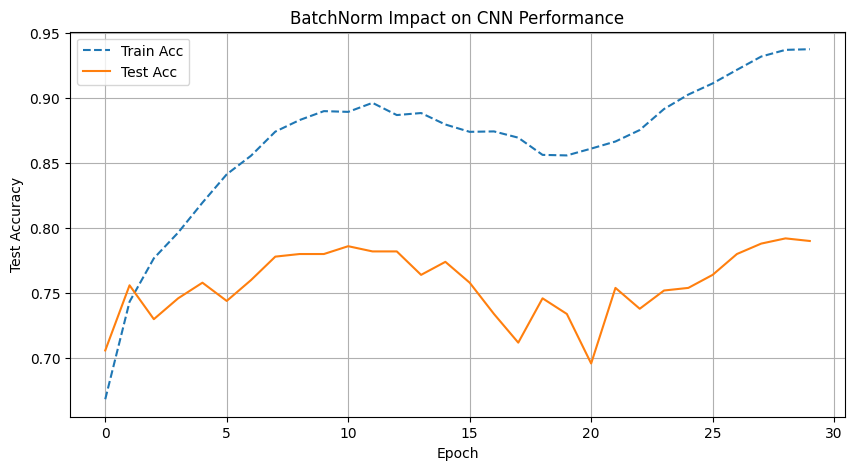

-----------------Experiment over-------------------------------
-----------------Experiment Start-------------------------------
Selected Pre-Trained Model Name: resnet18
Selected Optimizer:SGD, Scheduler:StepLR
StepSize:7, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9
Epoch 30, TrainAccuracy:73.60%,TestAccuracy:75.60%


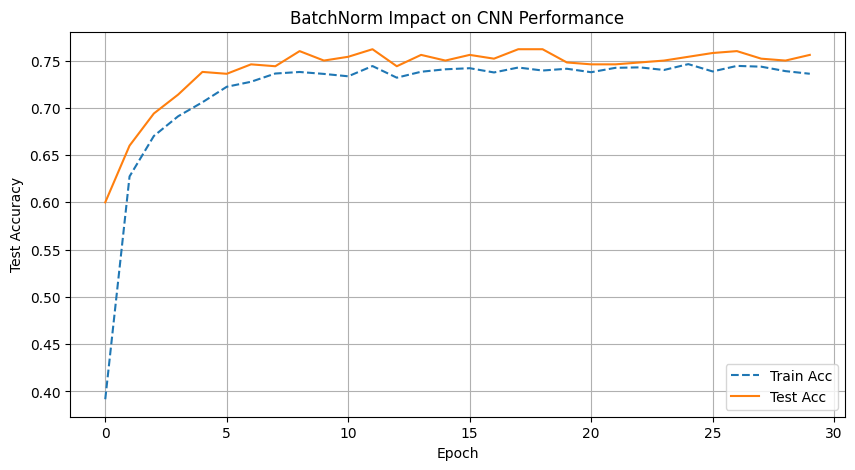

-----------------Experiment over-------------------------------
-----------------Experiment Start-------------------------------
Selected Pre-Trained Model Name: resnet18
Selected Optimizer:SGD, Scheduler:StepLR
StepSize:10, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9
Epoch 30, TrainAccuracy:76.05%,TestAccuracy:76.40%


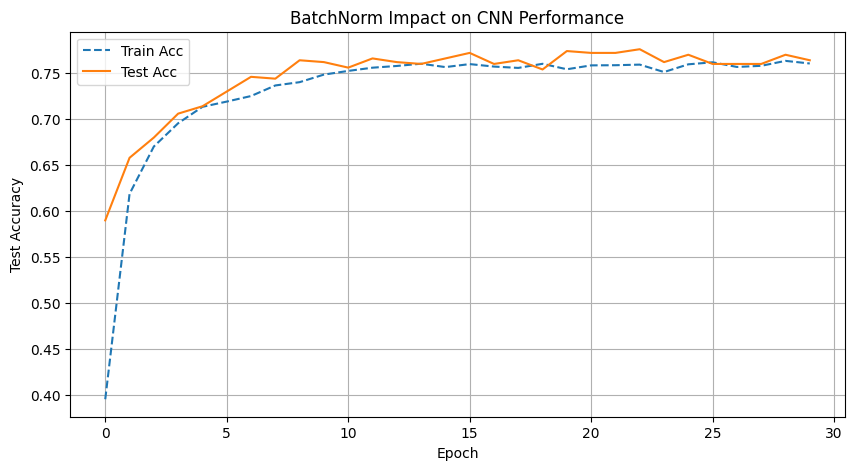

-----------------Experiment over-------------------------------
-----------------Experiment Start-------------------------------
Selected Pre-Trained Model Name: resnet18
Selected Optimizer:SGD, Scheduler:CosineAnnealingLR
StepSize:7, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9
Epoch 30, TrainAccuracy:77.34%,TestAccuracy:76.60%


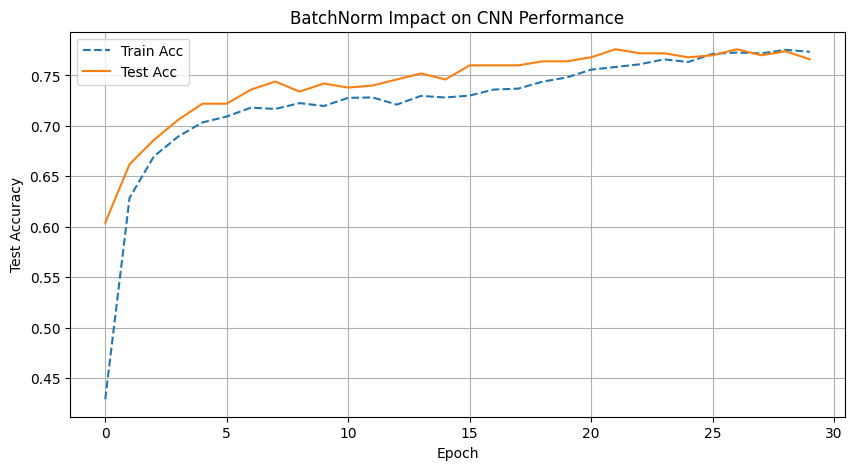

-----------------Experiment over-------------------------------
-----------------Experiment Start-------------------------------
Selected Pre-Trained Model Name: resnet34
Selected Optimizer:Adam, Scheduler:StepLR
StepSize:10, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9
Epoch 30, TrainAccuracy:93.65%,TestAccuracy:79.60%


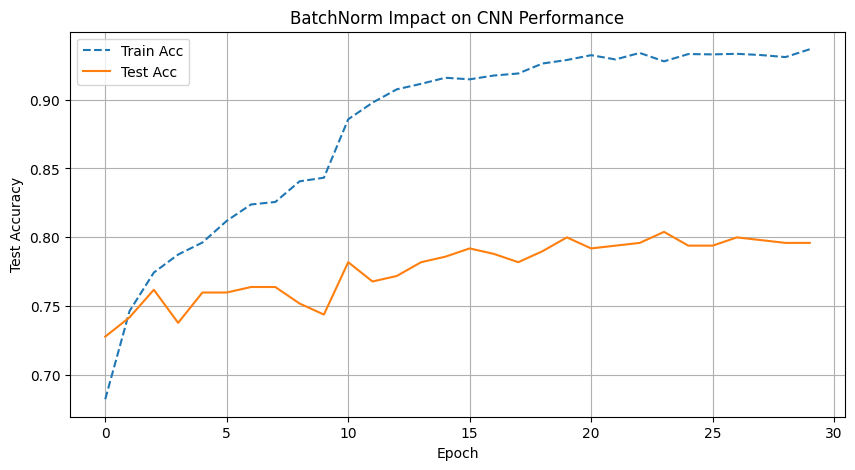

-----------------Experiment over-------------------------------
-----------------Experiment Start-------------------------------
Selected Pre-Trained Model Name: resnet34
Selected Optimizer:Adam, Scheduler:CosineAnnealingLR
StepSize:7, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9
Epoch 30, TrainAccuracy:94.67%,TestAccuracy:77.80%


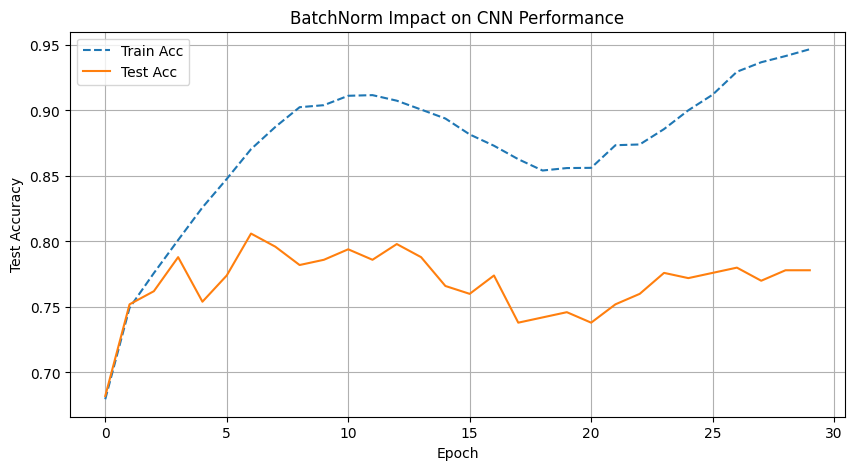

-----------------Experiment over-------------------------------
-----------------Experiment Start-------------------------------
Selected Pre-Trained Model Name: resnet34
Selected Optimizer:SGD, Scheduler:StepLR
StepSize:7, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9
Epoch 30, TrainAccuracy:77.89%,TestAccuracy:77.60%


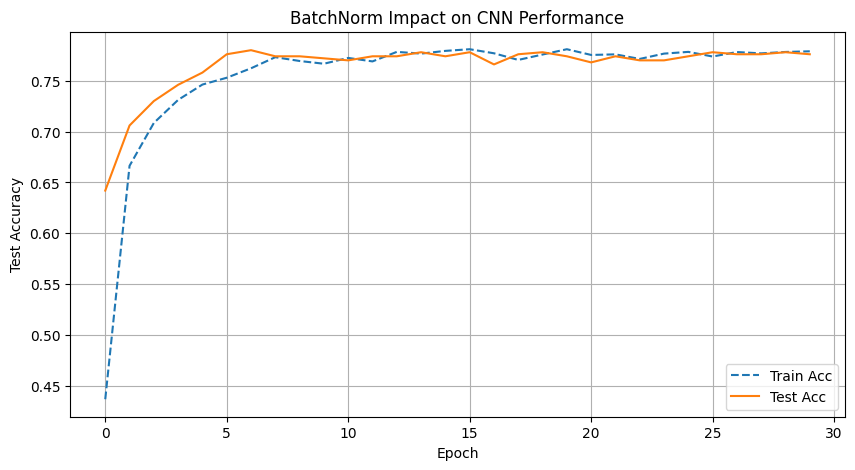

-----------------Experiment over-------------------------------
-----------------Experiment Start-------------------------------
Selected Pre-Trained Model Name: resnet34
Selected Optimizer:SGD, Scheduler:StepLR
StepSize:10, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9
Epoch 30, TrainAccuracy:79.41%,TestAccuracy:80.60%


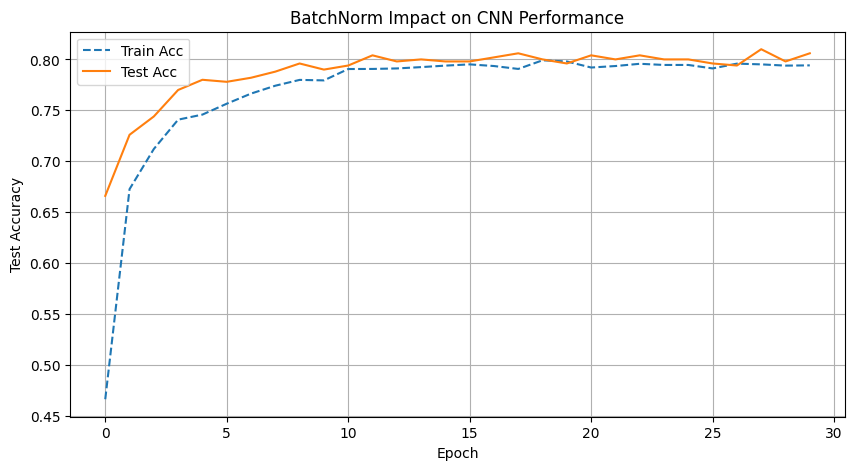

-----------------Experiment over-------------------------------
-----------------Experiment Start-------------------------------
Selected Pre-Trained Model Name: resnet34
Selected Optimizer:SGD, Scheduler:CosineAnnealingLR
StepSize:7, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9
Epoch 30, TrainAccuracy:80.93%,TestAccuracy:79.40%


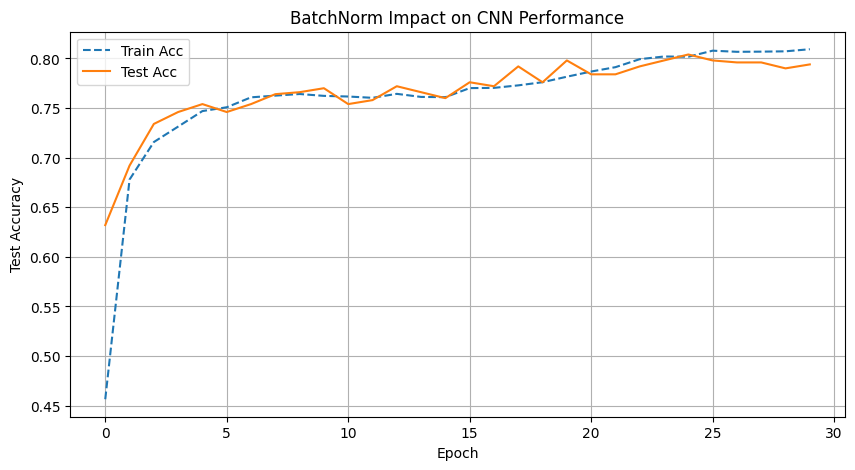

-----------------Experiment over-------------------------------
-----------------Experiment Start-------------------------------
Selected Pre-Trained Model Name: vgg19
Selected Optimizer:Adam, Scheduler:StepLR
StepSize:10, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9
Epoch 30, TrainAccuracy:90.43%,TestAccuracy:78.60%


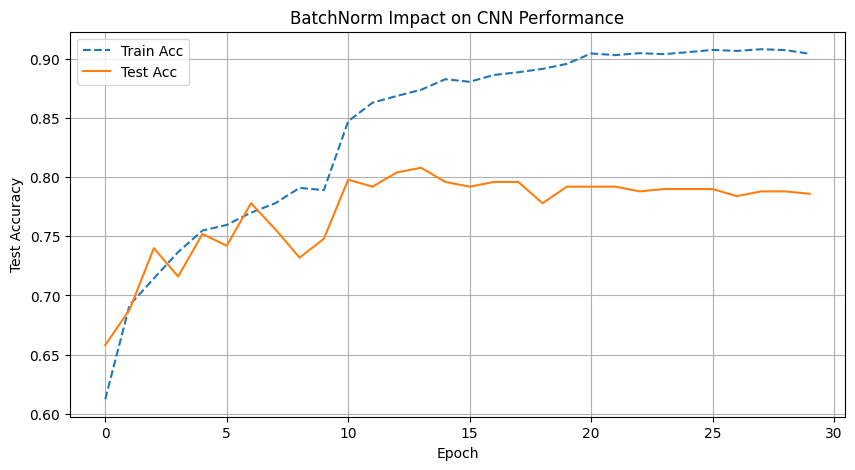

-----------------Experiment over-------------------------------
-----------------Experiment Start-------------------------------
Selected Pre-Trained Model Name: vgg19
Selected Optimizer:Adam, Scheduler:CosineAnnealingLR
StepSize:7, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9
Epoch 30, TrainAccuracy:92.43%,TestAccuracy:79.20%


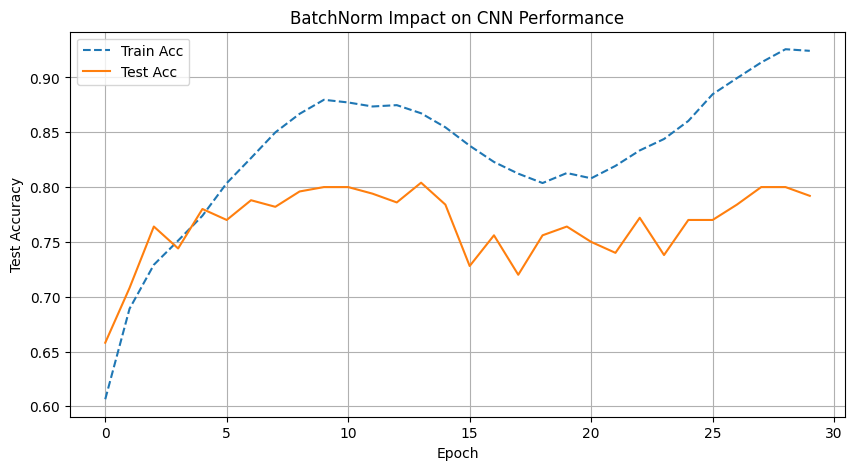

-----------------Experiment over-------------------------------
-----------------Experiment Start-------------------------------
Selected Pre-Trained Model Name: vgg19
Selected Optimizer:SGD, Scheduler:StepLR
StepSize:7, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9
Epoch 30, TrainAccuracy:79.92%,TestAccuracy:80.80%


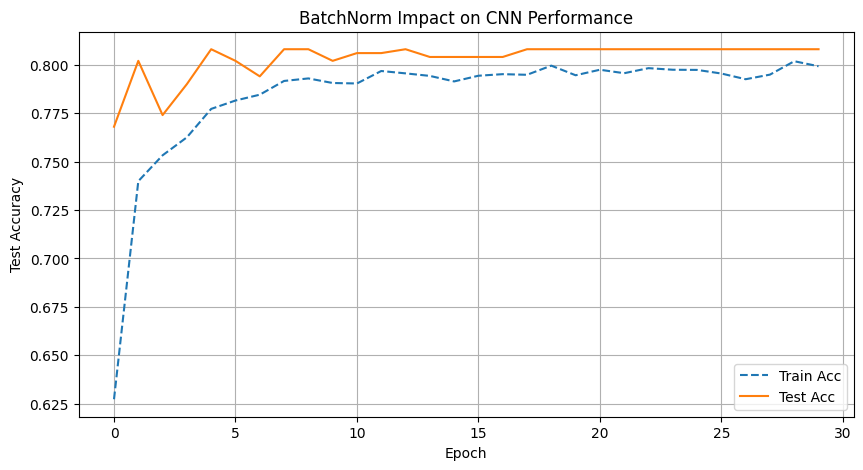

-----------------Experiment over-------------------------------
-----------------Experiment Start-------------------------------
Selected Pre-Trained Model Name: vgg19
Selected Optimizer:SGD, Scheduler:StepLR
StepSize:10, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9
Epoch 30, TrainAccuracy:80.53%,TestAccuracy:80.20%


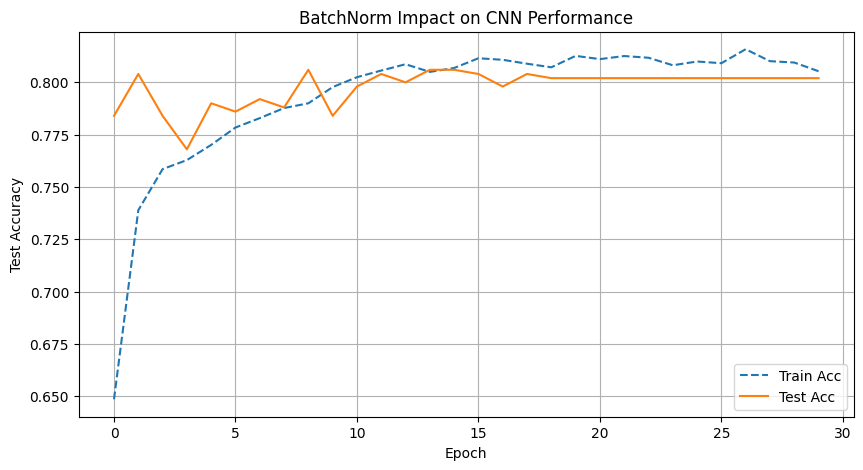

-----------------Experiment over-------------------------------
-----------------Experiment Start-------------------------------
Selected Pre-Trained Model Name: vgg19
Selected Optimizer:SGD, Scheduler:CosineAnnealingLR
StepSize:7, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9
Epoch 30, TrainAccuracy:81.70%,TestAccuracy:80.00%


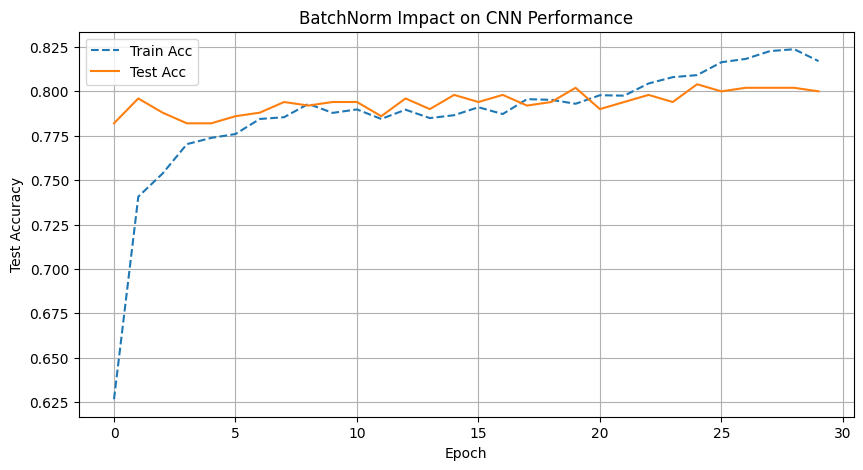

-----------------Experiment over-------------------------------


In [ ]:
# STEP 7 contd: More Experiment with different pre-trained model and parameters
# model_RESNET18_Adam_SLR_lr0001_mom09_decay0001_step10
model = training_diff_model(model_name='resnet18',
                        train_loader=train_loader, val_loader=val_loader,
                        optimizer_name='Adam', lr=0.0001, momentum=0.9,
                        weight_decay=0.0001, scheduler_name='StepLR',
                        step_size=10,gamma=0.1)
#save the model
torch.save(model, 'model_RESNET18_Adam_SLR_lr0001_mom09_decay0001_step10.pth')

# model_RESNET18_Adam_CSLR_lr0001_mom09_decay0001_step7
model = training_diff_model(model_name='resnet18',
                        train_loader=train_loader, val_loader=val_loader,
                        optimizer_name='Adam', lr=0.0001, momentum=0.9,
                        weight_decay=0.0001, scheduler_name='CosineAnnealingLR',
                        step_size=7,gamma=0.1)
#save the model
torch.save(model, 'model_RESNET18_Adam_CSLR_lr0001_mom09_decay0001_step7.pth')

# model_RESNET18_SGD_SLR_lr0001_mom09_decay0001_step7
model = training_diff_model(model_name='resnet18',
                        train_loader=train_loader, val_loader=val_loader,
                        optimizer_name='SGD', lr=0.0001, momentum=0.9,
                        weight_decay=0.0001, scheduler_name='StepLR',
                        step_size=7,gamma=0.1)
#save the model
torch.save(model, 'model_RESNET18_SGD_SLR_lr0001_mom09_decay0001_step7.pth')

# model_RESNET18_SGD_SLR_lr0001_mom09_decay0001_step10
model = training_diff_model(model_name='resnet18',
                        train_loader=train_loader, val_loader=val_loader,
                        optimizer_name='SGD', lr=0.0001, momentum=0.9,
                        weight_decay=0.0001, scheduler_name='StepLR',
                        step_size=10,gamma=0.1)
#save the model
torch.save(model, 'model_RESNET18_SGD_SLR_lr0001_mom09_decay0001_step10.pth')

# model_RESNET18_SGD_CSLR_lr0001_mom09_decay0001_step7
model = training_diff_model(model_name='resnet18',
                        train_loader=train_loader, val_loader=val_loader,
                        optimizer_name='SGD', lr=0.0001, momentum=0.9,
                        weight_decay=0.0001, scheduler_name='CosineAnnealingLR',
                        step_size=7,gamma=0.1)
#save the model
torch.save(model, 'model_RESNET18_SGD_CSLR_lr0001_mom09_decay0001_step7.pth')

# model_RESNET34_Adam_SLR_lr0001_mom09_decay0001_step10
model = training_diff_model(model_name='resnet34',
                        train_loader=train_loader, val_loader=val_loader,
                        optimizer_name='Adam', lr=0.0001, momentum=0.9,
                        weight_decay=0.0001, scheduler_name='StepLR',
                        step_size=10,gamma=0.1)
#save the model
torch.save(model, 'model_RESNET34_Adam_SLR_lr0001_mom09_decay0001_step10.pth')

# model_RESNET34_Adam_CSLR_lr0001_mom09_decay0001_step7
model= training_diff_model(model_name='resnet34',
                        train_loader=train_loader, val_loader=val_loader,
                        optimizer_name='Adam', lr=0.0001, momentum=0.9,
                        weight_decay=0.0001, scheduler_name='CosineAnnealingLR',
                        step_size=7,gamma=0.1)
#save the model
torch.save(model, 'model_RESNET34_Adam_CSLR_lr0001_mom09_decay0001_step7.pth')

# model_RESNET34_SGD_SLR_lr0001_mom09_decay0001_step7
model = training_diff_model(model_name='resnet34',
                        train_loader=train_loader, val_loader=val_loader,
                        optimizer_name='SGD', lr=0.0001, momentum=0.9,
                        weight_decay=0.0001, scheduler_name='StepLR',
                        step_size=7,gamma=0.1)
#save the model
torch.save(model, 'model_RESNET34_SGD_SLR_lr0001_mom09_decay0001_step7.pth')

# model_RESNET34_SGD_CSLR_lr0001_mom09_decay0001_step10
model = training_diff_model(model_name='resnet34',
                        train_loader=train_loader, val_loader=val_loader,
                        optimizer_name='SGD', lr=0.0001, momentum=0.9,
                        weight_decay=0.0001, scheduler_name='StepLR',
                        step_size=10,gamma=0.1)
#save the model
torch.save(model, 'model_RESNET34_SGD_CSLR_lr0001_mom09_decay0001_step10.pth')

# model_RESNET34_SGD_CSLR_lr0001_mom09_decay0001_step7
model = training_diff_model(model_name='resnet34',
                        train_loader=train_loader, val_loader=val_loader,
                        optimizer_name='SGD', lr=0.0001, momentum=0.9,
                        weight_decay=0.0001, scheduler_name='CosineAnnealingLR',
                        step_size=7,gamma=0.1)
#save the model
torch.save(model, 'model_RESNET34_SGD_CSLR_lr0001_mom09_decay0001_step7.pth')

# model_VGG19_Adam_SLR_lr0001_mom09_decay0001_step10
model = training_diff_model(model_name='vgg19',
                        train_loader=train_loader, val_loader=val_loader,
                        optimizer_name='Adam', lr=0.0001, momentum=0.9,
                        weight_decay=0.0001, scheduler_name='StepLR',
                        step_size=10,gamma=0.1)
#save the model
torch.save(model, 'model_VGG19_Adam_SLR_lr0001_mom09_decay0001_step10.pth')

# model_VGG19_Adam_CSLR_lr0001_mom09_decay0001_step7
model = training_diff_model(model_name='vgg19',
                        train_loader=train_loader, val_loader=val_loader,
                        optimizer_name='Adam', lr=0.0001, momentum=0.9,
                        weight_decay=0.0001, scheduler_name='CosineAnnealingLR',
                        step_size=7,gamma=0.1)
#save the model
torch.save(model, 'model_VGG19_Adam_CSLR_lr0001_mom09_decay0001_step7.pth')

# model_VGG19_SGD_SLR_lr0001_mom09_decay0001_step7
model = training_diff_model(model_name='vgg19',
                        train_loader=train_loader, val_loader=val_loader,
                        optimizer_name='SGD', lr=0.0001, momentum=0.9,
                        weight_decay=0.0001, scheduler_name='StepLR',
                        step_size=7,gamma=0.1)
#save the model
torch.save(model, 'model_VGG19_SGD_SLR_lr0001_mom09_decay0001_step7.pth')

# model_VGG19_SGD_SLR_lr0001_mom09_decay0001_step10
model = training_diff_model(model_name='vgg19',
                        train_loader=train_loader, val_loader=val_loader,
                        optimizer_name='SGD', lr=0.0001, momentum=0.9,
                        weight_decay=0.0001, scheduler_name='StepLR',
                        step_size=10,gamma=0.1)
#save the model
torch.save(model, 'model_VGG19_SGD_SLR_lr0001_mom09_decay0001_step10.pth')

# model_VGG19_SGD_CSLR_lr0001_mom09_decay0001_step7
model = training_diff_model(model_name='vgg19',
                        train_loader=train_loader, val_loader=val_loader,
                        optimizer_name='SGD', lr=0.0001, momentum=0.9,
                        weight_decay=0.0001, scheduler_name='CosineAnnealingLR',
                        step_size=7,gamma=0.1)
#save the model
torch.save(model, 'model_VGG19_SGD_CSLR_lr0001_mom09_decay0001_step7.pth')

In [9]:
# STEP 8: Unzip test folder for evaluating and generalizing
import zipfile
import os
# Path to the ZIP file
zip_path = "/content/Dataset5.zip"


# Directory where you want to extract
extestdataset_path = "/content/testex"

# Create the directory if it doesn't exist
os.makedirs(extestdataset_path, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extestdataset_path)

print(f"Dataset extracted to: {extestdataset_path}")

Dataset extracted to: /content/testex


In [13]:
# STEP 9:  Get dataloader for Test dataset

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Constants for preprocessing
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 224
BATCH_SIZE = 24  # Example batch size, can be adjusted

# Define transforms for validation and test (no augmentation)
# Resize 224x224 and Normalize, Add random cropping and flipping
# Imported transform from torchvision
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

def get_dataloaders_testset(dataset_path, batch_size=BATCH_SIZE):

    test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test",
                                        transform=test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, num_workers=4, pin_memory=True)

    return test_loader

In [14]:
# STEP 10: Evaluating the test data with 3 models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# STEP 10.1: Evaluating the test data with model-1

#Eval Exp: Model1 model_RESNET18_Adam_SLR_lr0001_mom09_decay0001_step7
model_eval = torch.load('model_RESNET18_Adam_SLR_lr0001_mom09_decay0001_step7.pth', weights_only=False)
# Validate the New test data
print(f"Test Classification :model_RESNET18_Adam_SLR_lr0001_mom09_decay0001_step7 ")
num_epochs = 30  # Increase number of epochs
test_loader = get_dataloaders_testset('/content/testex/Dataset5')
test_acc_list = test_loop(model_eval, test_loader, num_epochs)


Test Classification :model_RESNET18_Adam_SLR_lr0001_mom09_decay0001_step7 
Epoch 30, TestAccuracy:78.80%,TestLoss:76.55%


In [15]:
# STEP 10.2: Evaluating the test data with model-2

#Eval Exp: Model2 model_RESNET34_Adam_SLR_lr0001_mom09_decay0001_step7
model_eval = torch.load('model_RESNET34_Adam_SLR_lr0001_mom09_decay0001_step7.pth', weights_only=False)
# Validate the New test data
print(f"Test Classification :model_RESNET34_Adam_SLR_lr0001_mom09_decay0001_step7 ")
num_epochs = 30  # Increase number of epochs
test_loader = get_dataloaders_testset('/content/testex/Dataset5')
test_acc_list = test_loop(model_eval, test_loader, num_epochs)

Test Classification :model_RESNET34_Adam_SLR_lr0001_mom09_decay0001_step7 
Epoch 30, TestAccuracy:79.60%,TestLoss:82.61%


In [16]:
# STEP 10.3: Evaluating the test data with model-3

#Eval Exp: Model3 model_VGG19_Adam_SLR_lr0001_mom09_decay0001_step7
model_eval = torch.load('model_VGG19_Adam_SLR_lr0001_mom09_decay0001_step7.pth', weights_only=False)
# Validate the New test data
print(f"Test Classification :model_VGG19_Adam_SLR_lr0001_mom09_decay0001_step7 ")
num_epochs = 30  # Increase number of epochs
test_loader = get_dataloaders_testset('/content/testex/Dataset5')
test_acc_list = test_loop(model_eval, test_loader, num_epochs)


Test Classification :model_VGG19_Adam_SLR_lr0001_mom09_decay0001_step7 
Epoch 30, TestAccuracy:79.60%,TestLoss:71.89%



**SUMMARY**
----------

**Selected Pre-Trained Model Name: resnet18**
Selected Optimizer:Adam, Scheduler:StepLR
StepSize:7, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9

Epoch 30, **TrainAccuracy:89.94%,TrainLoss:30.77%**

Epoch 30, **ValAccuracy:78.80%,ValLoss:76.40%**

Test Classification :model_RESNET18_Adam_SLR_lr0001_mom09_decay0001_step7

Epoch 30, **TestAccuracy:78.80%,TestLoss:76.55%**

----------------------------------------------------------------------
**Selected Pre-Trained Model Name: resnet34**
Selected Optimizer:Adam, Scheduler:StepLR
StepSize:7, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9

Epoch 30, **TrainAccuracy:91.83%,TrainLoss:24.43%**

Epoch 30, **ValAccuracy:79.60%,ValLoss:82.45%**
Test Classification :model_RESNET34_Adam_SLR_lr0001_mom09_decay0001_step7

Epoch 30, **TestAccuracy:79.60%,TestLoss:82.61%**

-----------------------------------------------------------------------

**Selected Pre-Trained Model Name: vgg19**
Selected Optimizer:Adam, Scheduler:StepLR
StepSize:7, LR:0.0001, Gamma:0.1
WgtDecay:0.0001, Momentum:0.9

Epoch 30, **TrainAccuracy:87.66%,TrainLoss:38.01%**

Epoch 30, **ValAccuracy:79.60%,ValLoss:71.75%**
Test Classification :model_VGG19_Adam_SLR_lr0001_mom09_decay0001_step7

Epoch 30, **TestAccuracy:79.60%,TestLoss:71.89%**

----------------------------------------------------------------------